## For overwriting COV2 sequences ##
R2 contains a sequence motif that causes the quality to drop precipitously. This notebook overwrites the reverse read where there are no mutations and merges the two reads manually.

             R1
---X--X------X-----X---X--->  

              <-----------------||||||||--  
             
                        R2
                        
             R1
---X--X------X-----X---X--->|----WT----||||||||  

### Take reverse complement and save as merged.csv ###


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import sys

In [2]:
# ASCII values of DNA characters.
bA = ord("A")
bC = ord("C")
bG = ord("G")
bT = ord("T")
bN = ord("N")


def reverse_complement(s):
    t = np.zeros_like(s)
    v = t[::-1]
    v[s == bA] = bT
    v[s == bC] = bG
    v[s == bG] = bC
    v[s == bT] = bA
    v[s == bN] = bN
    return t


def str_to_byte_array(s):
    return np.array(bytearray(s, "ascii"), dtype=np.int8)


def byte_array_to_str(a):
    return a.tobytes().decode("ascii")


def open_by_extension(path, mode):
    """Open a file using gzip.open if its name ends with '.gz', otherwise
    use open."""
    return (gzip.open if path.endswith("gz") else open)(path, mode)


def read_line(f):
    """Read a line from f with trailing whitespace stripped.

    Unlike f.readline(), this function raises an EOFError instead of returning
    an empty string at the end of the file.
    """
    line = f.readline()
    if len(line) == 0:
        raise EOFError
    return line.rstrip()


def read_seqs(f):
    """Generate FASTQ records as tuples from an open file handle."""
    while True:
        # Read the sequence ID. If there's nothing to read, then we're done.
        try:
            seq_id = read_line(f)
        except EOFError:
            return

        # If we successfully read a sequence ID, then running out of stuff to
        # read means a truncated record.
        try:
            seq = str_to_byte_array(str(read_line(f)))
            qual_id = read_line(f)
            qual = str_to_byte_array(str(read_line(f)))
        except EOFError:
            raise EOFError("EOF while reading sequence.")

        # Some simple checks of the data.
        if seq_id[0] != "@":
            raise ValueError("Sequence ID doesn't begin with '@'.")
        if qual_id[0] != "+":
            raise ValueError("Quality ID doesn't begin with '+'.")
        if len(seq) != len(qual):
            raise ValueError("Sequence and quality are different lengths.")

        yield (seq_id, seq, qual_id, qual)

In [7]:
### Modify these parameters
WT_SEQ = "agaaccagttctccctgaagctgagctctgtgaccgccgcagacacggctgtctattactgtgcgagacaatggaaatggttcggggaagcctggtacttcgatctctggggccgtggcaccctggtcactgtctcctcaacc".upper()
f1 = open_by_extension("/scratch/alpine/moki5314/MLE_25Feb2023/fab-library-barcoding-main-3/MBK_test_25Feb2023/17Apr/MBK-2_S2_L001_R1_001.fastq.gz", "rt")
f2 = open_by_extension("/scratch/alpine/moki5314/MLE_25Feb2023/fab-library-barcoding-main-3/MBK_test_25Feb2023/17Apr/MBK-2_S2_L001_R2_001.fastq.gz", "rt")
output_name = "merged_test_COV2_VH6_rep2.csv"
fwd_match = "TGCTAGCGTTTTAGCAGGTcagctgcagctgcaggagtcgggcccaggactggtgaagccttcggagacactgtccctcacatgcactgtctctggtggctccatcagcagt".upper()

i = 0
ids, seqs, quals, amplens = [], [], [], []

for i, (s1, s2) in enumerate(zip(read_seqs(f1), read_seqs(f2))):
    if i % 100000 == 0:
        print(i)
    id_val1, seq1, space1, qual1 = s1
    id_val2, seq2, space2, qual2 = s2
    seq_str1 = byte_array_to_str(seq1)[:248]
    rev_read = byte_array_to_str(seq2)[:36]
    if seq_str1[:112] == fwd_match:
        fwd_read = seq_str1 + WT_SEQ
        fwd_read = byte_array_to_str(reverse_complement(str_to_byte_array(fwd_read)))
        if min(qual1) > 10 + 33:
            merged = rev_read + fwd_read
            ids.append(id_val1.split(" ")[0] + str(" merged"))
            seqs.append(merged)
            quals.append(qual1)
            amplens.append(len(merged))
        else:
            continue
    i += 1

output_df = pd.DataFrame({"ID": ids, "Seq": seqs, "Qual": quals, "Amplen": amplens})
output_df.to_csv(output_name, index=False)
print("Total sequences:", len(output_df))

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
Total sequences: 240523


/projects/brpe7306/software/anaconda/envsa/ml_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/projects/brpe7306/software/anaconda/envsa/ml_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


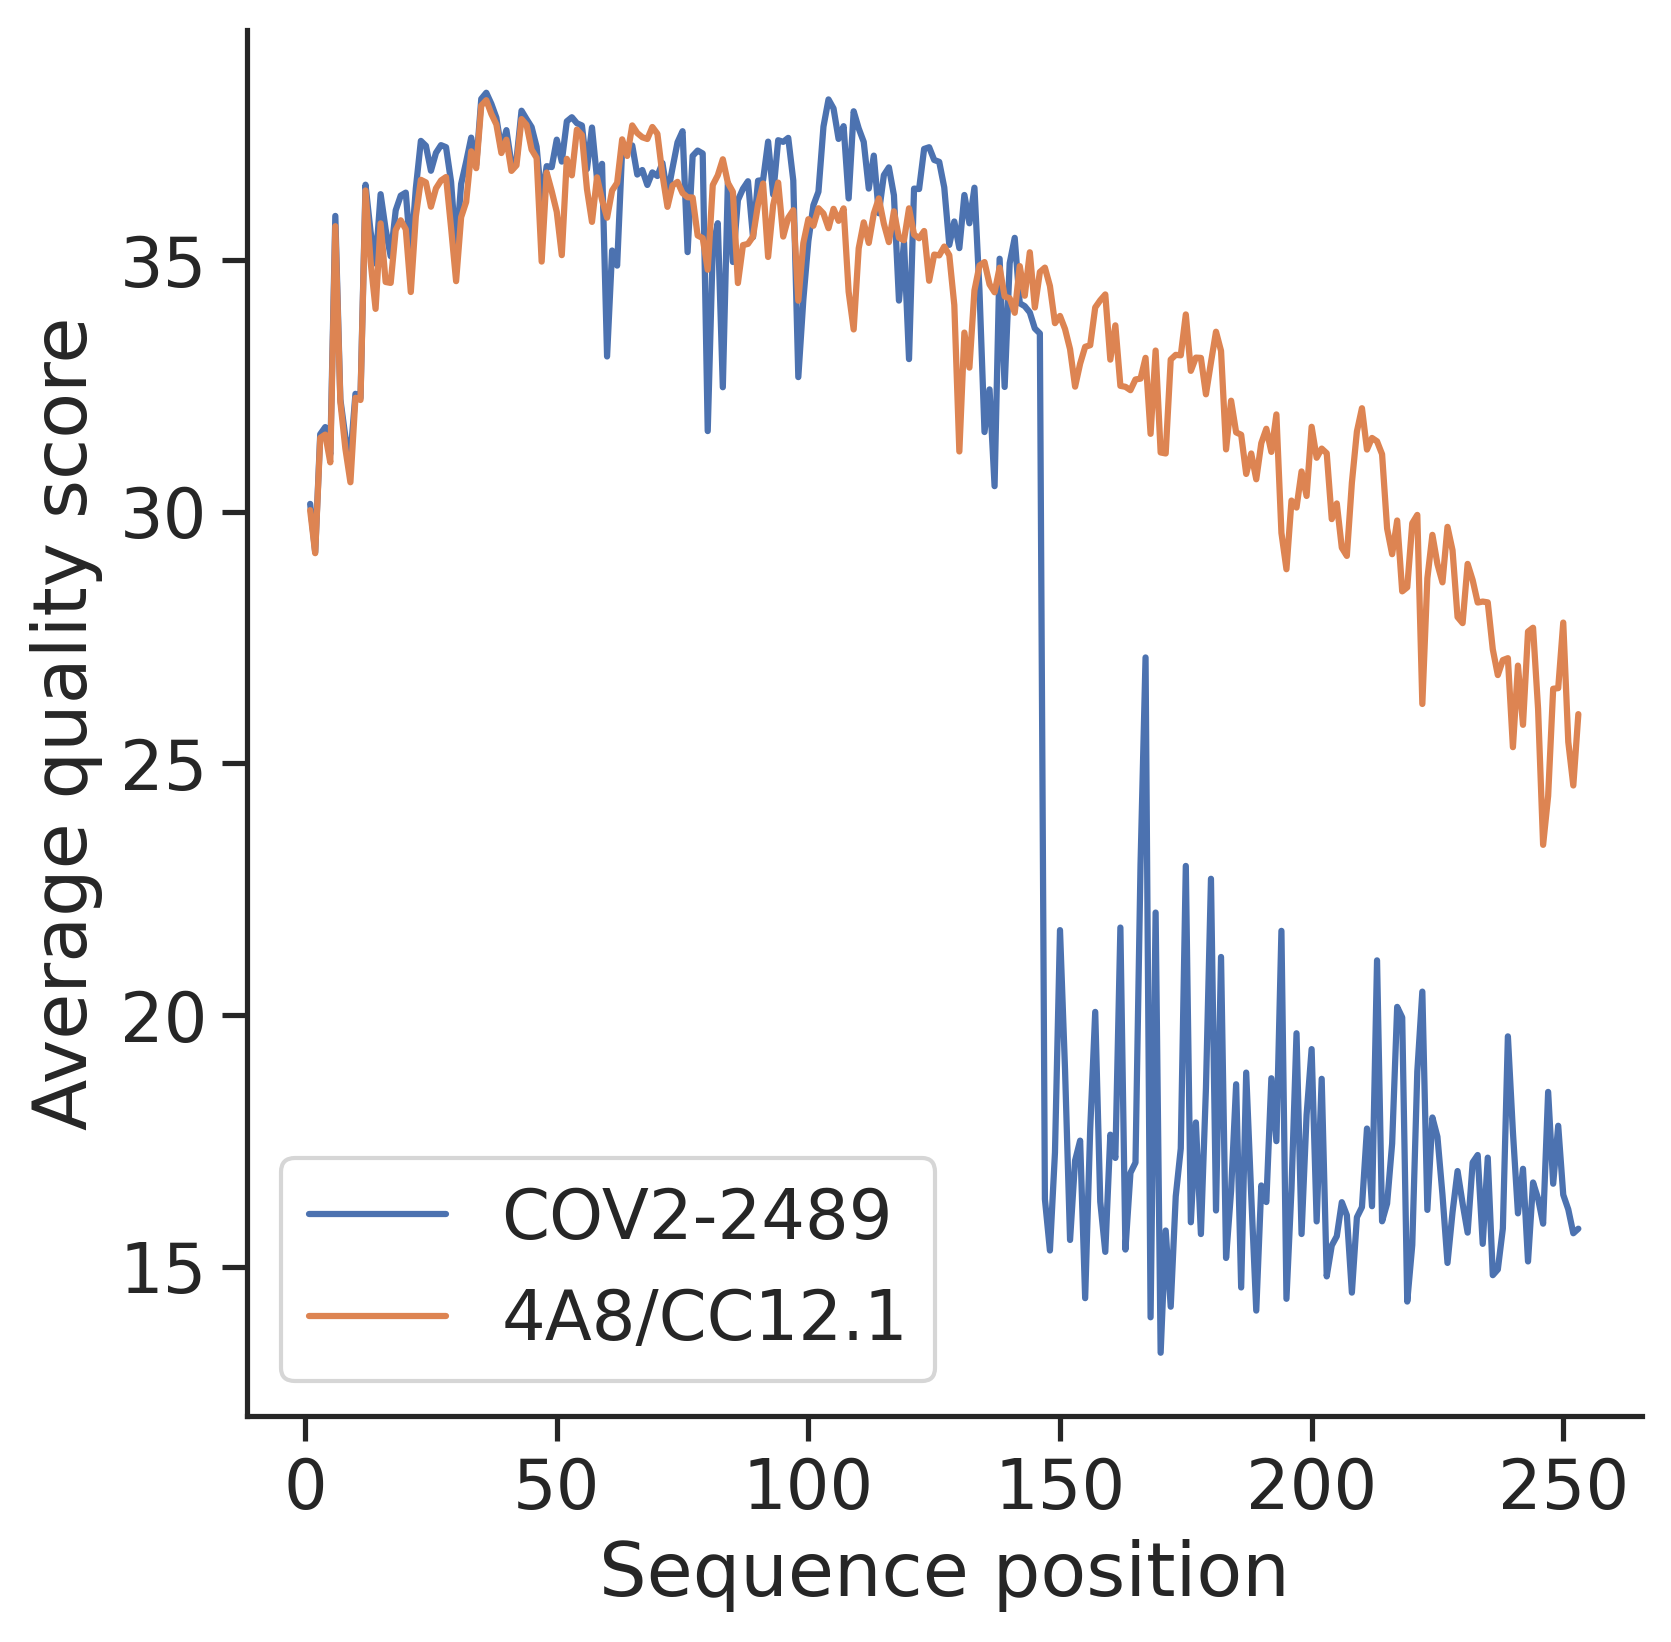

<Figure size 1800x1800 with 0 Axes>

In [29]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (6, 6),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

f1 = open_by_extension("/scratch/alpine/moki5314/MLE_25Feb2023/fab-library-barcoding-main-3/MBK_test_25Feb2023/17Apr/MBK-2_S2_L001_R1_001.fastq.gz", "rt")
f2 = open_by_extension("/scratch/alpine/moki5314/MLE_25Feb2023/fab-library-barcoding-main-3/MBK_test_25Feb2023/17Apr/MBK-2_S2_L001_R2_001.fastq.gz", "rt")
fwd_match = "TGCTAGCGTTTTAGCAGGTcagctgcagctgcaggagtcgggcccaggactggtgaagccttcggagacactgtccctcacatgcactgtctctggtggctccatcagcagt".upper()

q = []
q_other = []
for i, (s1, s) in enumerate(zip(read_seqs(f1), read_seqs(f2))):
    id_val1, seq1, space1, qual1 = s1
    id_val, seq, space, qual = s
    seq_str1 = byte_array_to_str(seq1)[:248]
    if seq_str1[:112] == fwd_match:
        q.append([val-33 for val in qual])
    else:
        q_other.append([val-33 for val in qual])
    if i == 100000:
        break
q_mean = np.mean(q, axis=0)
q_other_mean = np.mean(q_other, axis=0)
pos = [j+1 for j in range(len(q_mean))]
sns.lineplot(pos, q_mean, label='COV2-2489')
sns.lineplot(pos, q_other_mean, label='4A8/CC12.1')
plt.xlabel("Sequence position")
plt.ylabel("Average quality score")
plt.savefig("COV2_qual.png")
plt.show()
plt.clf()
# for i in range(len(pos)):
#     print(pos[i], q_mean[i])